# Advantage Actor Critic (A2C) Method

Advantage Actor-Critic (A2C) is a reinforcement learning algorithm that combines elements from policy gradient methods (like REINFORCE) and value-based methods (like Q-learning). The A2C algorithm aims to learn an optimal policy by iteratively improving the actor and critic networks.

#### Requirements  

gym==0.22.0
<br> torch==1.13.1
<br> seaborn==0.12.2
<br> pandas==1.3.5
<br> tqdm==4.65.0

In [1]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import seaborn as sns

In [2]:
torch.__version__

'1.13.1'

### Define the Actor network

In [3]:
class Actor(nn.Module):

    def __init__(self, state_dim,  action_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, action_dim)

    def forward(self, state):
        x1 = F.relu(self.fc1(state))
        x2 = F.relu(self.fc2(x1))
        action_probs = F.softmax(self.fc3(x2), dim=-1)
        return action_probs

### Define the Critic network

In [4]:
class Critic(nn.Module):

    def __init__(self, state_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, state):
        x1 = F.relu(self.fc1(state))
        x2 = F.relu(self.fc2(x1))
        value = self.fc3(x2)
        return value

### Create the CartPole-v1 environment

In [5]:
env = gym.make("CartPole-v1")
env.seed(0)

state_dim = env.observation_space.shape[0]
n_actions = env.action_space.n

### Configure A2C

In [6]:
actor = Actor(state_dim, n_actions)
critic = Critic(state_dim)
adam_actor = torch.optim.Adam(actor.parameters(), lr=1e-3)
adam_critic = torch.optim.Adam(critic.parameters(), lr=1e-3)
gamma = 0.99

### Training

In [7]:
# Set the number of episodes to run the algorithm
num_episodes=500

# Initialize a list to store the total rewards obtained in each episode
episode_rewards = []

# Initialize a dictionary to store the losses and the returns
stats={'actor loss':[], 'critic loss':[], 'return':[]}

# Initialize tqdm progress bar
pbar = tqdm(total=num_episodes, ncols=80, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt}')

for episode in range(num_episodes):
    done = False
    total_reward = 0
    state = env.reset()
    env.seed(0)

    while not done:
        
        probs = actor(torch.from_numpy(state).float())
        dist = torch.distributions.Categorical(probs=probs)
        action = dist.sample()
        
        next_state, reward, done, info = env.step(action.detach().data.numpy())

        # Compute the advantage function
        advantage = reward + (1-done)*gamma*critic(torch.from_numpy(next_state).float()) - critic(torch.from_numpy(state).float())        

        # Update the reward and the state                   
        total_reward += reward
        state = next_state

        # Calculate the critic and the actor losses
        critic_loss = advantage.pow(2).mean()
        adam_critic.zero_grad()
        critic_loss.backward()
        adam_critic.step()

        actor_loss = -dist.log_prob(action)*advantage.detach()
        
        adam_actor.zero_grad()
        actor_loss.backward()
        adam_actor.step()
    
    # Store the total reward obtained in the episode    
    episode_rewards.append(total_reward)

    # Store the losses and the returns
    stats['actor loss'].append(actor_loss)
    stats['critic loss'].append(critic_loss)
    stats['return'].append(total_reward)

    # Print the losses and the returns
    print('Actor loss= ', round(stats['actor loss'][episode].item(), 4), 'Critic loss= ', round(stats['critic loss'][episode].item(), 4), 'Return= ', stats['return'][episode])

    # Update tqdm progress bar
    pbar.set_description(f"Episode {episode + 1}")
    pbar.set_postfix({"Reward": episode_rewards})
    pbar.update(1)

# Close tqdm progress bar
pbar.close()

Episode 2:   0%|▏                                                        | 2/500

Actor loss=  0.6915 Critic loss=  1.0032 Return=  22.0
Actor loss=  0.4547 Critic loss=  0.564 Return=  18.0


Episode 5:   1%|▍                                                        | 4/500

Actor loss=  0.4585 Critic loss=  0.5283 Return=  18.0
Actor loss=  0.5869 Critic loss=  0.4629 Return=  14.0
Actor loss=  0.5287 Critic loss=  0.4333 Return=  10.0


Episode 7:   1%|▋                                                        | 6/500

Actor loss=  0.5659 Critic loss=  0.669 Return=  16.0
Actor loss=  0.3333 Critic loss=  0.3407 Return=  13.0


Episode 9:   2%|▉                                                        | 8/500

Actor loss=  0.3514 Critic loss=  0.2789 Return=  25.0
Actor loss=  0.4979 Critic loss=  0.4162 Return=  12.0


Episode 11:   2%|█▏                                                     | 11/500

Actor loss=  0.5982 Critic loss=  0.5476 Return=  16.0
Actor loss=  0.3722 Critic loss=  0.2371 Return=  24.0


Episode 13:   3%|█▍                                                     | 13/500

Actor loss=  0.2232 Critic loss=  0.1162 Return=  43.0
Actor loss=  0.1511 Critic loss=  0.0623 Return=  16.0


Episode 15:   3%|█▋                                                     | 15/500

Actor loss=  0.204 Critic loss=  0.1135 Return=  15.0
Actor loss=  0.3148 Critic loss=  0.214 Return=  11.0


Episode 16:   3%|█▊                                                     | 16/500

Actor loss=  0.1193 Critic loss=  0.0271 Return=  11.0


Episode 18:   4%|█▉                                                     | 18/500

Actor loss=  0.0414 Critic loss=  0.0031 Return=  29.0
Actor loss=  0.1078 Critic loss=  0.0262 Return=  16.0


Episode 20:   4%|██▏                                                    | 20/500

Actor loss=  0.1415 Critic loss=  0.033 Return=  10.0
Actor loss=  0.1937 Critic loss=  0.0879 Return=  10.0


Episode 23:   4%|██▍                                                    | 22/500

Actor loss=  0.1326 Critic loss=  0.0355 Return=  16.0
Actor loss=  0.2064 Critic loss=  0.0903 Return=  9.0
Actor loss=  0.4367 Critic loss=  0.3897 Return=  9.0


Episode 24:   5%|██▋                                                    | 24/500

Actor loss=  0.1761 Critic loss=  0.071 Return=  11.0


Episode 25:   5%|██▊                                                    | 25/500

Actor loss=  -0.253 Critic loss=  0.1136 Return=  50.0


Episode 27:   5%|██▉                                                    | 27/500

Actor loss=  0.1799 Critic loss=  0.0691 Return=  29.0
Actor loss=  -0.2445 Critic loss=  0.13 Return=  10.0


Episode 28:   6%|███                                                    | 28/500

Actor loss=  -0.056 Critic loss=  0.007 Return=  20.0


Episode 29:   6%|███▏                                                   | 29/500

Actor loss=  -0.0383 Critic loss=  0.0028 Return=  26.0


Episode 30:   6%|███▎                                                   | 30/500

Actor loss=  0.607 Critic loss=  0.7273 Return=  17.0


Episode 31:   6%|███▍                                                   | 31/500

Actor loss=  0.0519 Critic loss=  0.0051 Return=  46.0


Episode 34:   7%|███▋                                                   | 33/500

Actor loss=  -0.1988 Critic loss=  0.0874 Return=  30.0
Actor loss=  -0.0195 Critic loss=  0.0008 Return=  16.0
Actor loss=  -0.39 Critic loss=  0.4725 Return=  10.0


Episode 36:   7%|███▉                                                   | 36/500

Actor loss=  -0.5371 Critic loss=  0.6921 Return=  18.0
Actor loss=  0.0355 Critic loss=  0.0026 Return=  25.0


Episode 38:   8%|████▏                                                  | 38/500

Actor loss=  0.2294 Critic loss=  0.1178 Return=  14.0
Actor loss=  0.492 Critic loss=  0.7475 Return=  10.0


Episode 39:   8%|████▎                                                  | 39/500

Actor loss=  0.5461 Critic loss=  0.7136 Return=  19.0


Episode 40:   8%|████▍                                                  | 40/500

Actor loss=  -0.2178 Critic loss=  0.1091 Return=  27.0


Episode 42:   8%|████▌                                                  | 41/500

Actor loss=  0.0293 Critic loss=  0.0016 Return=  49.0
Actor loss=  -1.0247 Critic loss=  1.5952 Return=  18.0


Episode 44:   9%|████▋                                                  | 43/500

Actor loss=  0.1501 Critic loss=  0.088 Return=  45.0
Actor loss=  -0.3276 Critic loss=  0.1427 Return=  13.0


Episode 46:   9%|█████                                                  | 46/500

Actor loss=  -0.7794 Critic loss=  0.8407 Return=  42.0
Actor loss=  -0.2879 Critic loss=  0.3348 Return=  10.0


Episode 48:  10%|█████▎                                                 | 48/500

Actor loss=  -0.3292 Critic loss=  0.1533 Return=  18.0
Actor loss=  -0.0664 Critic loss=  0.0126 Return=  17.0


Episode 50:  10%|█████▍                                                 | 49/500

Actor loss=  -0.5928 Critic loss=  0.3431 Return=  29.0
Actor loss=  0.1789 Critic loss=  0.14 Return=  25.0


Episode 51:  10%|█████▌                                                 | 51/500

Actor loss=  0.9653 Critic loss=  1.2402 Return=  46.0


Episode 52:  10%|█████▋                                                 | 52/500

Actor loss=  -0.1767 Critic loss=  0.106 Return=  35.0


Episode 53:  11%|█████▊                                                 | 53/500

Actor loss=  0.4138 Critic loss=  0.237 Return=  38.0


Episode 54:  11%|█████▉                                                 | 54/500

Actor loss=  -0.9708 Critic loss=  3.6831 Return=  44.0


Episode 55:  11%|██████                                                 | 55/500

Actor loss=  -0.1154 Critic loss=  0.0517 Return=  25.0


Episode 56:  11%|██████▏                                                | 56/500

Actor loss=  -0.0473 Critic loss=  0.011 Return=  31.0


Episode 57:  11%|██████▎                                                | 57/500

Actor loss=  -0.5642 Critic loss=  2.5106 Return=  39.0


Episode 58:  12%|██████▍                                                | 58/500

Actor loss=  -2.0189 Critic loss=  2.1617 Return=  94.0


Episode 59:  12%|██████▍                                                | 59/500

Actor loss=  -0.4487 Critic loss=  1.3489 Return=  39.0


Episode 60:  12%|██████▌                                                | 60/500

Actor loss=  -0.0724 Critic loss=  0.0786 Return=  88.0


Episode 61:  12%|██████▋                                                | 61/500

Actor loss=  -0.6373 Critic loss=  1.4581 Return=  31.0


Episode 62:  12%|██████▊                                                | 62/500

Actor loss=  -1.2079 Critic loss=  1.2733 Return=  22.0


Episode 63:  13%|██████▉                                                | 63/500

Actor loss=  -0.8902 Critic loss=  0.2991 Return=  30.0


Episode 64:  13%|███████                                                | 64/500

Actor loss=  0.0297 Critic loss=  0.1659 Return=  55.0


Episode 65:  13%|███████▏                                               | 65/500

Actor loss=  -0.1106 Critic loss=  0.0101 Return=  69.0


Episode 66:  13%|███████▎                                               | 66/500

Actor loss=  -0.219 Critic loss=  0.0623 Return=  56.0


Episode 67:  13%|███████▎                                               | 67/500

Actor loss=  -0.1363 Critic loss=  0.097 Return=  81.0


Episode 68:  14%|███████▍                                               | 68/500

Actor loss=  0.5324 Critic loss=  0.9157 Return=  61.0


Episode 69:  14%|███████▌                                               | 69/500

Actor loss=  -0.8778 Critic loss=  0.6839 Return=  45.0


Episode 70:  14%|███████▋                                               | 70/500

Actor loss=  -0.5377 Critic loss=  1.5424 Return=  27.0


Episode 71:  14%|███████▊                                               | 71/500

Actor loss=  -0.1925 Critic loss=  0.7064 Return=  34.0


Episode 72:  14%|███████▉                                               | 72/500

Actor loss=  -0.1384 Critic loss=  0.0429 Return=  29.0


Episode 73:  15%|████████                                               | 73/500

Actor loss=  -0.0501 Critic loss=  0.0073 Return=  39.0


Episode 75:  15%|████████▏                                              | 74/500

Actor loss=  -0.0562 Critic loss=  0.5328 Return=  29.0
Actor loss=  -0.6184 Critic loss=  0.3238 Return=  22.0


Episode 77:  15%|████████▍                                              | 77/500

Actor loss=  -0.0982 Critic loss=  0.0048 Return=  26.0
Actor loss=  0.0305 Critic loss=  0.0033 Return=  25.0


Episode 78:  16%|████████▌                                              | 78/500

Actor loss=  0.8559 Critic loss=  1.659 Return=  44.0


Episode 79:  16%|████████▋                                              | 79/500

Actor loss=  0.1002 Critic loss=  0.0391 Return=  44.0


Episode 80:  16%|████████▊                                              | 80/500

Actor loss=  0.0089 Critic loss=  0.0033 Return=  39.0


Episode 81:  16%|████████▉                                              | 81/500

Actor loss=  -0.0357 Critic loss=  0.0102 Return=  46.0
Actor loss=  -0.1111 Critic loss=  0.0954 Return=  31.0


Episode 83:  17%|█████████▏                                             | 83/500

Actor loss=  0.0268 Critic loss=  1.6298 Return=  47.0


Episode 85:  17%|█████████▎                                             | 85/500

Actor loss=  -0.0387 Critic loss=  1.537 Return=  28.0
Actor loss=  -0.0514 Critic loss=  1.7944 Return=  25.0


Episode 86:  17%|█████████▍                                             | 86/500

Actor loss=  0.0308 Critic loss=  0.1243 Return=  30.0


Episode 87:  17%|█████████▌                                             | 87/500

Actor loss=  0.1987 Critic loss=  0.297 Return=  33.0


Episode 88:  18%|█████████▋                                             | 88/500

Actor loss=  0.2529 Critic loss=  4.1396 Return=  44.0


Episode 89:  18%|█████████▊                                             | 89/500

Actor loss=  -0.169 Critic loss=  0.1323 Return=  36.0


Episode 90:  18%|█████████▉                                             | 90/500

Actor loss=  0.0048 Critic loss=  0.5124 Return=  49.0


Episode 91:  18%|██████████                                             | 91/500

Actor loss=  -0.0146 Critic loss=  0.3346 Return=  35.0


Episode 92:  18%|██████████                                             | 92/500

Actor loss=  0.1507 Critic loss=  0.4241 Return=  53.0


Episode 93:  19%|██████████▏                                            | 93/500

Actor loss=  0.6674 Critic loss=  0.3882 Return=  47.0


Episode 94:  19%|██████████▎                                            | 94/500

Actor loss=  0.2284 Critic loss=  0.1714 Return=  47.0


Episode 95:  19%|██████████▍                                            | 95/500

Actor loss=  -2.1514 Critic loss=  17.3343 Return=  25.0


Episode 97:  19%|██████████▌                                            | 96/500

Actor loss=  -0.0419 Critic loss=  0.3943 Return=  38.0
Actor loss=  -0.0151 Critic loss=  0.6936 Return=  27.0


Episode 99:  20%|██████████▊                                            | 98/500

Actor loss=  0.3824 Critic loss=  1.5519 Return=  31.0
Actor loss=  -0.6794 Critic loss=  0.9224 Return=  27.0


Episode 100:  20%|██████████▌                                          | 100/500

Actor loss=  1.1914 Critic loss=  5.379 Return=  50.0


Episode 101:  20%|██████████▋                                          | 101/500

Actor loss=  1.2195 Critic loss=  1.5744 Return=  46.0


Episode 103:  20%|██████████▊                                          | 102/500

Actor loss=  -1.3952 Critic loss=  6.7141 Return=  29.0
Actor loss=  -0.0308 Critic loss=  0.6432 Return=  28.0


Episode 105:  21%|███████████                                          | 104/500

Actor loss=  0.0171 Critic loss=  1.1565 Return=  38.0
Actor loss=  -0.0082 Critic loss=  2.5071 Return=  27.0


Episode 107:  21%|███████████▏                                         | 106/500

Actor loss=  -0.1324 Critic loss=  1.1791 Return=  24.0
Actor loss=  -0.016 Critic loss=  0.6395 Return=  25.0


Episode 109:  22%|███████████▌                                         | 109/500

Actor loss=  0.0336 Critic loss=  0.0404 Return=  30.0
Actor loss=  -0.046 Critic loss=  0.0672 Return=  24.0


Episode 110:  22%|███████████▋                                         | 110/500

Actor loss=  -0.3823 Critic loss=  0.9908 Return=  22.0


Episode 111:  22%|███████████▊                                         | 111/500

Actor loss=  0.192 Critic loss=  0.9973 Return=  30.0


Episode 113:  22%|███████████▊                                         | 112/500

Actor loss=  0.1846 Critic loss=  2.8431 Return=  36.0
Actor loss=  -0.0141 Critic loss=  4.9227 Return=  22.0


Episode 115:  23%|████████████▏                                        | 115/500

Actor loss=  -0.2426 Critic loss=  5.013 Return=  19.0
Actor loss=  0.1223 Critic loss=  0.0374 Return=  22.0


Episode 117:  23%|████████████▎                                        | 116/500

Actor loss=  0.2874 Critic loss=  5.3155 Return=  26.0
Actor loss=  0.3371 Critic loss=  3.3285 Return=  28.0


Episode 119:  24%|████████████▌                                        | 118/500

Actor loss=  0.0498 Critic loss=  0.078 Return=  30.0
Actor loss=  0.2404 Critic loss=  0.138 Return=  31.0


Episode 120:  24%|████████████▋                                        | 120/500

Actor loss=  0.6314 Critic loss=  4.3488 Return=  34.0


Episode 121:  24%|████████████▊                                        | 121/500

Actor loss=  0.053 Critic loss=  1.2624 Return=  39.0


Episode 122:  24%|████████████▉                                        | 122/500

Actor loss=  0.0171 Critic loss=  2.3251 Return=  43.0


Episode 123:  25%|█████████████                                        | 123/500

Actor loss=  -0.1348 Critic loss=  0.0376 Return=  38.0


Episode 124:  25%|█████████████▏                                       | 124/500

Actor loss=  0.0401 Critic loss=  0.038 Return=  43.0


Episode 125:  25%|█████████████▎                                       | 125/500

Actor loss=  0.0561 Critic loss=  5.2595 Return=  46.0


Episode 126:  25%|█████████████▎                                       | 126/500

Actor loss=  -0.3346 Critic loss=  2.03 Return=  36.0


Episode 127:  25%|█████████████▍                                       | 127/500

Actor loss=  -0.3323 Critic loss=  0.0957 Return=  44.0


Episode 128:  26%|█████████████▌                                       | 128/500

Actor loss=  0.1473 Critic loss=  2.8294 Return=  54.0


Episode 129:  26%|█████████████▋                                       | 129/500

Actor loss=  0.5872 Critic loss=  4.6789 Return=  60.0


Episode 130:  26%|█████████████▊                                       | 130/500

Actor loss=  -1.0022 Critic loss=  11.6393 Return=  39.0


Episode 131:  26%|█████████████▉                                       | 131/500

Actor loss=  6.3275 Critic loss=  3.0865 Return=  68.0


Episode 132:  26%|█████████████▉                                       | 132/500

Actor loss=  0.414 Critic loss=  14.3903 Return=  79.0


Episode 133:  27%|██████████████                                       | 133/500

Actor loss=  -1.5375 Critic loss=  7.5877 Return=  45.0


Episode 134:  27%|██████████████▏                                      | 134/500

Actor loss=  -0.6855 Critic loss=  3.0504 Return=  50.0


Episode 135:  27%|██████████████▎                                      | 135/500

Actor loss=  -0.3224 Critic loss=  7.421 Return=  37.0


Episode 136:  27%|██████████████▍                                      | 136/500

Actor loss=  0.2451 Critic loss=  10.2407 Return=  48.0


Episode 137:  27%|██████████████▌                                      | 137/500

Actor loss=  2.2444 Critic loss=  12.59 Return=  58.0


Episode 138:  28%|██████████████▋                                      | 138/500

Actor loss=  -1.311 Critic loss=  4.9641 Return=  52.0


Episode 139:  28%|██████████████▋                                      | 139/500

Actor loss=  -7.2029 Critic loss=  611.0401 Return=  57.0


Episode 140:  28%|██████████████▊                                      | 140/500

Actor loss=  2.6215 Critic loss=  6.6641 Return=  88.0


Episode 141:  28%|██████████████▉                                      | 141/500

Actor loss=  0.3625 Critic loss=  5.2968 Return=  70.0


Episode 142:  28%|███████████████                                      | 142/500

Actor loss=  0.0666 Critic loss=  0.0189 Return=  43.0


Episode 143:  29%|███████████████▏                                     | 143/500

Actor loss=  -0.0325 Critic loss=  2.6236 Return=  38.0


Episode 144:  29%|███████████████▎                                     | 144/500

Actor loss=  0.6439 Critic loss=  0.5029 Return=  44.0


Episode 145:  29%|███████████████▎                                     | 145/500

Actor loss=  0.3918 Critic loss=  6.373 Return=  56.0


Episode 146:  29%|███████████████▍                                     | 146/500

Actor loss=  -0.0588 Critic loss=  0.1093 Return=  79.0


Episode 147:  29%|███████████████▌                                     | 147/500

Actor loss=  -0.0492 Critic loss=  4.2392 Return=  38.0


Episode 148:  30%|███████████████▋                                     | 148/500

Actor loss=  0.0157 Critic loss=  0.0327 Return=  41.0


Episode 149:  30%|███████████████▊                                     | 149/500

Actor loss=  0.0385 Critic loss=  1.9155 Return=  43.0


Episode 150:  30%|███████████████▉                                     | 150/500

Actor loss=  2.4354 Critic loss=  8.8501 Return=  68.0


Episode 151:  30%|████████████████                                     | 151/500

Actor loss=  -0.128 Critic loss=  0.1966 Return=  44.0


Episode 152:  30%|████████████████                                     | 152/500

Actor loss=  -2.6385 Critic loss=  315.298 Return=  73.0


Episode 153:  31%|████████████████▏                                    | 153/500

Actor loss=  -2.5145 Critic loss=  109.3897 Return=  102.0


Episode 154:  31%|████████████████▎                                    | 154/500

Actor loss=  0.488 Critic loss=  7.2357 Return=  79.0


Episode 155:  31%|████████████████▍                                    | 155/500

Actor loss=  0.4884 Critic loss=  4.1139 Return=  57.0


Episode 156:  31%|████████████████▌                                    | 156/500

Actor loss=  0.1563 Critic loss=  3.6668 Return=  65.0


Episode 157:  31%|████████████████▋                                    | 157/500

Actor loss=  0.3602 Critic loss=  2.3638 Return=  165.0


Episode 158:  32%|████████████████▋                                    | 158/500

Actor loss=  0.1547 Critic loss=  0.0251 Return=  47.0


Episode 159:  32%|████████████████▊                                    | 159/500

Actor loss=  0.0133 Critic loss=  0.4369 Return=  52.0


Episode 160:  32%|████████████████▉                                    | 160/500

Actor loss=  -1.086 Critic loss=  0.4979 Return=  48.0


Episode 161:  32%|█████████████████                                    | 161/500

Actor loss=  -0.0951 Critic loss=  0.1041 Return=  48.0


Episode 162:  32%|█████████████████▏                                   | 162/500

Actor loss=  -0.0192 Critic loss=  0.6097 Return=  37.0


Episode 163:  33%|█████████████████▎                                   | 163/500

Actor loss=  -0.0764 Critic loss=  1.5281 Return=  37.0


Episode 164:  33%|█████████████████▍                                   | 164/500

Actor loss=  -0.0195 Critic loss=  0.1477 Return=  33.0


Episode 165:  33%|█████████████████▍                                   | 165/500

Actor loss=  -0.0004 Critic loss=  0.004 Return=  36.0


Episode 166:  33%|█████████████████▌                                   | 166/500

Actor loss=  0.0559 Critic loss=  0.5859 Return=  57.0


Episode 167:  33%|█████████████████▋                                   | 167/500

Actor loss=  -0.1125 Critic loss=  0.919 Return=  33.0


Episode 168:  34%|█████████████████▊                                   | 168/500

Actor loss=  -0.1691 Critic loss=  12.5244 Return=  26.0


Episode 169:  34%|█████████████████▉                                   | 169/500

Actor loss=  0.0013 Critic loss=  0.472 Return=  33.0


Episode 170:  34%|██████████████████                                   | 170/500

Actor loss=  -0.1634 Critic loss=  0.1382 Return=  37.0


Episode 171:  34%|██████████████████▏                                  | 171/500

Actor loss=  0.0802 Critic loss=  0.0525 Return=  27.0


Episode 172:  34%|██████████████████▏                                  | 172/500

Actor loss=  1.5437 Critic loss=  1.2867 Return=  37.0


Episode 173:  35%|██████████████████▎                                  | 173/500

Actor loss=  0.0256 Critic loss=  0.4798 Return=  36.0


Episode 174:  35%|██████████████████▍                                  | 174/500

Actor loss=  -0.1282 Critic loss=  17.1864 Return=  25.0


Episode 175:  35%|██████████████████▌                                  | 175/500

Actor loss=  0.0619 Critic loss=  1.3902 Return=  30.0


Episode 176:  35%|██████████████████▋                                  | 176/500

Actor loss=  -0.0408 Critic loss=  4.3124 Return=  29.0


Episode 177:  35%|██████████████████▊                                  | 177/500

Actor loss=  0.1708 Critic loss=  10.8365 Return=  39.0


Episode 178:  36%|██████████████████▊                                  | 178/500

Actor loss=  0.249 Critic loss=  0.4019 Return=  33.0


Episode 179:  36%|██████████████████▉                                  | 179/500

Actor loss=  -1.0184 Critic loss=  2.3529 Return=  31.0


Episode 180:  36%|███████████████████                                  | 180/500

Actor loss=  0.0503 Critic loss=  6.6691 Return=  42.0


Episode 181:  36%|███████████████████▏                                 | 181/500

Actor loss=  0.6879 Critic loss=  6.2512 Return=  52.0


Episode 182:  36%|███████████████████▎                                 | 182/500

Actor loss=  0.7113 Critic loss=  1.8291 Return=  46.0


Episode 183:  37%|███████████████████▍                                 | 183/500

Actor loss=  0.2256 Critic loss=  3.6656 Return=  52.0


Episode 184:  37%|███████████████████▌                                 | 184/500

Actor loss=  5.0712 Critic loss=  5.1151 Return=  69.0


Episode 185:  37%|███████████████████▌                                 | 185/500

Actor loss=  0.1304 Critic loss=  2.3848 Return=  78.0


Episode 186:  37%|███████████████████▋                                 | 186/500

Actor loss=  3.8678 Critic loss=  9.976 Return=  117.0


Episode 187:  37%|███████████████████▊                                 | 187/500

Actor loss=  -3.2586 Critic loss=  383.4934 Return=  89.0


Episode 188:  38%|███████████████████▉                                 | 188/500

Actor loss=  0.6935 Critic loss=  2.6131 Return=  77.0


Episode 189:  38%|████████████████████                                 | 189/500

Actor loss=  -7.7122 Critic loss=  94.7298 Return=  44.0


Episode 190:  38%|████████████████████▏                                | 190/500

Actor loss=  -0.7565 Critic loss=  60.7062 Return=  31.0


Episode 191:  38%|████████████████████▏                                | 191/500

Actor loss=  -2.9723 Critic loss=  48.8367 Return=  24.0


Episode 192:  38%|████████████████████▎                                | 192/500

Actor loss=  -3.0628 Critic loss=  58.9872 Return=  46.0


Episode 193:  39%|████████████████████▍                                | 193/500

Actor loss=  -0.8678 Critic loss=  30.8996 Return=  61.0


Episode 194:  39%|████████████████████▌                                | 194/500

Actor loss=  -7.6101 Critic loss=  164.6046 Return=  148.0


Episode 195:  39%|████████████████████▋                                | 195/500

Actor loss=  0.4292 Critic loss=  2.0786 Return=  48.0


Episode 196:  39%|████████████████████▊                                | 196/500

Actor loss=  1.7582 Critic loss=  3.3273 Return=  76.0


Episode 197:  39%|████████████████████▉                                | 197/500

Actor loss=  -4.6207 Critic loss=  47.0389 Return=  63.0


Episode 198:  40%|████████████████████▉                                | 198/500

Actor loss=  1.2519 Critic loss=  1.5382 Return=  142.0


Episode 199:  40%|█████████████████████                                | 199/500

Actor loss=  0.0146 Critic loss=  3.512 Return=  179.0


Episode 200:  40%|█████████████████████▏                               | 200/500

Actor loss=  -2.1363 Critic loss=  63.1693 Return=  102.0


Episode 201:  40%|█████████████████████▎                               | 201/500

Actor loss=  -3.981 Critic loss=  18.2313 Return=  85.0


Episode 202:  40%|█████████████████████▍                               | 202/500

Actor loss=  -0.3614 Critic loss=  18.3685 Return=  84.0


Episode 203:  41%|█████████████████████▌                               | 203/500

Actor loss=  -0.5181 Critic loss=  5.8124 Return=  64.0


Episode 204:  41%|█████████████████████▌                               | 204/500

Actor loss=  -1.7563 Critic loss=  0.7945 Return=  158.0


Episode 205:  41%|█████████████████████▋                               | 205/500

Actor loss=  0.6065 Critic loss=  0.7972 Return=  117.0


Episode 206:  41%|█████████████████████▊                               | 206/500

Actor loss=  0.9445 Critic loss=  0.9185 Return=  82.0


Episode 207:  41%|█████████████████████▉                               | 207/500

Actor loss=  0.132 Critic loss=  0.6874 Return=  167.0


Episode 208:  42%|██████████████████████                               | 208/500

Actor loss=  0.2092 Critic loss=  0.488 Return=  110.0


Episode 209:  42%|██████████████████████▏                              | 209/500

Actor loss=  0.0533 Critic loss=  1.321 Return=  176.0


Episode 210:  42%|██████████████████████▎                              | 210/500

Actor loss=  -4.5692 Critic loss=  6.0677 Return=  56.0


Episode 211:  42%|██████████████████████▎                              | 211/500

Actor loss=  -0.282 Critic loss=  3.6472 Return=  70.0


Episode 212:  42%|██████████████████████▍                              | 212/500

Actor loss=  -0.0475 Critic loss=  1.1964 Return=  69.0


Episode 213:  43%|██████████████████████▌                              | 213/500

Actor loss=  -0.0473 Critic loss=  0.25 Return=  64.0


Episode 214:  43%|██████████████████████▋                              | 214/500

Actor loss=  0.0292 Critic loss=  0.1951 Return=  97.0


Episode 215:  43%|██████████████████████▊                              | 215/500

Actor loss=  -0.0512 Critic loss=  0.4628 Return=  131.0


Episode 216:  43%|██████████████████████▉                              | 216/500

Actor loss=  0.2638 Critic loss=  58.3208 Return=  344.0


Episode 217:  43%|███████████████████████                              | 217/500

Actor loss=  -0.1666 Critic loss=  86.9093 Return=  276.0


Episode 218:  44%|███████████████████████                              | 218/500

Actor loss=  -0.1043 Critic loss=  2.2155 Return=  278.0


Episode 219:  44%|███████████████████████▏                             | 219/500

Actor loss=  0.3328 Critic loss=  17.7366 Return=  206.0


Episode 220:  44%|███████████████████████▎                             | 220/500

Actor loss=  -0.4831 Critic loss=  53.9985 Return=  370.0


Episode 221:  44%|███████████████████████▍                             | 221/500

Actor loss=  -0.3273 Critic loss=  11.5051 Return=  157.0


Episode 222:  44%|███████████████████████▌                             | 222/500

Actor loss=  -1.0265 Critic loss=  9.6573 Return=  249.0


Episode 223:  45%|███████████████████████▋                             | 223/500

Actor loss=  -0.0024 Critic loss=  0.901 Return=  104.0


Episode 224:  45%|███████████████████████▋                             | 224/500

Actor loss=  -0.5333 Critic loss=  0.8941 Return=  133.0


Episode 225:  45%|███████████████████████▊                             | 225/500

Actor loss=  0.1431 Critic loss=  5.5379 Return=  101.0


Episode 226:  45%|███████████████████████▉                             | 226/500

Actor loss=  -0.0192 Critic loss=  9.9358 Return=  77.0


Episode 227:  45%|████████████████████████                             | 227/500

Actor loss=  -0.0734 Critic loss=  23.418 Return=  39.0


Episode 228:  46%|████████████████████████▏                            | 228/500

Actor loss=  -0.0206 Critic loss=  0.4616 Return=  52.0


Episode 229:  46%|████████████████████████▎                            | 229/500

Actor loss=  -0.0105 Critic loss=  1.1118 Return=  41.0


Episode 230:  46%|████████████████████████▍                            | 230/500

Actor loss=  -0.0077 Critic loss=  0.1729 Return=  39.0


Episode 231:  46%|████████████████████████▍                            | 231/500

Actor loss=  -0.0016 Critic loss=  0.7233 Return=  36.0


Episode 232:  46%|████████████████████████▌                            | 232/500

Actor loss=  0.0015 Critic loss=  1.9263 Return=  43.0


Episode 233:  47%|████████████████████████▋                            | 233/500

Actor loss=  0.0014 Critic loss=  0.1795 Return=  41.0


Episode 234:  47%|████████████████████████▊                            | 234/500

Actor loss=  0.0011 Critic loss=  0.0233 Return=  41.0


Episode 235:  47%|████████████████████████▉                            | 235/500

Actor loss=  -0.0151 Critic loss=  0.0933 Return=  39.0


Episode 236:  47%|█████████████████████████                            | 236/500

Actor loss=  -0.0013 Critic loss=  0.4371 Return=  36.0


Episode 237:  47%|█████████████████████████                            | 237/500

Actor loss=  -0.0543 Critic loss=  1.8689 Return=  32.0


Episode 238:  48%|█████████████████████████▏                           | 238/500

Actor loss=  -0.0008 Critic loss=  0.4783 Return=  31.0


Episode 239:  48%|█████████████████████████▎                           | 239/500

Actor loss=  0.2683 Critic loss=  5.3066 Return=  39.0


Episode 240:  48%|█████████████████████████▍                           | 240/500

Actor loss=  -0.3013 Critic loss=  2.5131 Return=  32.0


Episode 241:  48%|█████████████████████████▌                           | 241/500

Actor loss=  1.7807 Critic loss=  6.6443 Return=  44.0


Episode 242:  48%|█████████████████████████▋                           | 242/500

Actor loss=  -0.0024 Critic loss=  2.9795 Return=  31.0


Episode 243:  49%|█████████████████████████▊                           | 243/500

Actor loss=  0.0045 Critic loss=  1.7849 Return=  38.0


Episode 244:  49%|█████████████████████████▊                           | 244/500

Actor loss=  -0.0008 Critic loss=  0.5222 Return=  31.0


Episode 245:  49%|█████████████████████████▉                           | 245/500

Actor loss=  0.1118 Critic loss=  0.3109 Return=  35.0


Episode 246:  49%|██████████████████████████                           | 246/500

Actor loss=  -0.0001 Critic loss=  1.3623 Return=  32.0


Episode 247:  49%|██████████████████████████▏                          | 247/500

Actor loss=  -0.0028 Critic loss=  0.1874 Return=  31.0


Episode 248:  50%|██████████████████████████▎                          | 248/500

Actor loss=  0.0162 Critic loss=  2.8175 Return=  36.0


Episode 249:  50%|██████████████████████████▍                          | 249/500

Actor loss=  0.0109 Critic loss=  0.1135 Return=  34.0


Episode 250:  50%|██████████████████████████▌                          | 250/500

Actor loss=  0.0071 Critic loss=  0.3281 Return=  38.0


Episode 251:  50%|██████████████████████████▌                          | 251/500

Actor loss=  -0.0267 Critic loss=  0.0296 Return=  33.0


Episode 252:  50%|██████████████████████████▋                          | 252/500

Actor loss=  -1.2362 Critic loss=  0.7102 Return=  30.0


Episode 253:  51%|██████████████████████████▊                          | 253/500

Actor loss=  0.0421 Critic loss=  0.3798 Return=  34.0


Episode 254:  51%|██████████████████████████▉                          | 254/500

Actor loss=  0.8265 Critic loss=  1.26 Return=  35.0


Episode 255:  51%|███████████████████████████                          | 255/500

Actor loss=  -0.0823 Critic loss=  0.5203 Return=  32.0


Episode 256:  51%|███████████████████████████▏                         | 256/500

Actor loss=  5.2391 Critic loss=  3.7844 Return=  39.0


Episode 257:  51%|███████████████████████████▏                         | 257/500

Actor loss=  -0.0721 Critic loss=  7.6196 Return=  29.0


Episode 258:  52%|███████████████████████████▎                         | 258/500

Actor loss=  -0.0002 Critic loss=  0.0496 Return=  30.0


Episode 260:  52%|███████████████████████████▍                         | 259/500

Actor loss=  -0.0679 Critic loss=  0.5132 Return=  25.0
Actor loss=  -0.0459 Critic loss=  3.9415 Return=  24.0


Episode 262:  52%|███████████████████████████▋                         | 261/500

Actor loss=  0.1757 Critic loss=  1.8653 Return=  27.0
Actor loss=  1.2708 Critic loss=  2.564 Return=  30.0


Episode 263:  53%|███████████████████████████▉                         | 263/500

Actor loss=  0.0044 Critic loss=  0.6434 Return=  33.0


Episode 264:  53%|███████████████████████████▉                         | 264/500

Actor loss=  1.3438 Critic loss=  3.0768 Return=  39.0


Episode 265:  53%|████████████████████████████                         | 265/500

Actor loss=  -6.6985 Critic loss=  5.3862 Return=  29.0


Episode 266:  53%|████████████████████████████▏                        | 266/500

Actor loss=  0.0015 Critic loss=  1.2071 Return=  33.0


Episode 267:  53%|████████████████████████████▎                        | 267/500

Actor loss=  0.0028 Critic loss=  4.3143 Return=  42.0


Episode 268:  54%|████████████████████████████▍                        | 268/500

Actor loss=  0.0952 Critic loss=  0.593 Return=  39.0


Episode 269:  54%|████████████████████████████▌                        | 269/500

Actor loss=  -0.0537 Critic loss=  0.0175 Return=  37.0


Episode 270:  54%|████████████████████████████▌                        | 270/500

Actor loss=  0.0006 Critic loss=  0.0841 Return=  42.0


Episode 271:  54%|████████████████████████████▋                        | 271/500

Actor loss=  -0.0002 Critic loss=  0.0022 Return=  36.0


Episode 272:  54%|████████████████████████████▊                        | 272/500

Actor loss=  -0.1211 Critic loss=  0.171 Return=  37.0


Episode 273:  55%|████████████████████████████▉                        | 273/500

Actor loss=  0.0012 Critic loss=  1.1833 Return=  42.0


Episode 274:  55%|█████████████████████████████                        | 274/500

Actor loss=  -0.007 Critic loss=  0.3369 Return=  36.0


Episode 275:  55%|█████████████████████████████▏                       | 275/500

Actor loss=  0.0025 Critic loss=  0.1227 Return=  36.0


Episode 276:  55%|█████████████████████████████▎                       | 276/500

Actor loss=  0.0184 Critic loss=  1.8615 Return=  43.0


Episode 277:  55%|█████████████████████████████▎                       | 277/500

Actor loss=  -0.0052 Critic loss=  0.8678 Return=  36.0


Episode 278:  56%|█████████████████████████████▍                       | 278/500

Actor loss=  0.0048 Critic loss=  2.084 Return=  45.0


Episode 279:  56%|█████████████████████████████▌                       | 279/500

Actor loss=  0.0006 Critic loss=  0.3231 Return=  51.0


Episode 280:  56%|█████████████████████████████▋                       | 280/500

Actor loss=  0.1454 Critic loss=  2.3605 Return=  55.0


Episode 281:  56%|█████████████████████████████▊                       | 281/500

Actor loss=  -0.3378 Critic loss=  0.7418 Return=  49.0


Episode 282:  56%|█████████████████████████████▉                       | 282/500

Actor loss=  3.6243 Critic loss=  4.188 Return=  58.0


Episode 283:  57%|█████████████████████████████▉                       | 283/500

Actor loss=  -0.0055 Critic loss=  0.2537 Return=  57.0


Episode 284:  57%|██████████████████████████████                       | 284/500

Actor loss=  -0.4602 Critic loss=  0.9221 Return=  57.0


Episode 285:  57%|██████████████████████████████▏                      | 285/500

Actor loss=  0.0013 Critic loss=  0.7004 Return=  60.0


Episode 286:  57%|██████████████████████████████▎                      | 286/500

Actor loss=  0.2851 Critic loss=  1.2956 Return=  58.0


Episode 287:  57%|██████████████████████████████▍                      | 287/500

Actor loss=  -0.0079 Critic loss=  0.6497 Return=  61.0


Episode 288:  58%|██████████████████████████████▌                      | 288/500

Actor loss=  -0.0007 Critic loss=  0.1136 Return=  60.0


Episode 289:  58%|██████████████████████████████▋                      | 289/500

Actor loss=  0.7863 Critic loss=  7.3356 Return=  63.0


Episode 290:  58%|██████████████████████████████▋                      | 290/500

Actor loss=  0.1108 Critic loss=  0.155 Return=  81.0


Episode 291:  58%|██████████████████████████████▊                      | 291/500

Actor loss=  0.0319 Critic loss=  13.162 Return=  127.0


Episode 292:  58%|██████████████████████████████▉                      | 292/500

Actor loss=  -0.3229 Critic loss=  6.9164 Return=  111.0


Episode 293:  59%|███████████████████████████████                      | 293/500

Actor loss=  -0.0421 Critic loss=  0.8437 Return=  145.0


Episode 294:  59%|███████████████████████████████▏                     | 294/500

Actor loss=  0.0586 Critic loss=  8.5908 Return=  117.0


Episode 295:  59%|███████████████████████████████▎                     | 295/500

Actor loss=  -2.6396 Critic loss=  18.822 Return=  94.0


Episode 296:  59%|███████████████████████████████▍                     | 296/500

Actor loss=  0.0391 Critic loss=  0.1429 Return=  149.0


Episode 297:  59%|███████████████████████████████▍                     | 297/500

Actor loss=  -1.2462 Critic loss=  16.9154 Return=  133.0


Episode 298:  60%|███████████████████████████████▌                     | 298/500

Actor loss=  -45.9597 Critic loss=  646.0172 Return=  94.0


Episode 299:  60%|███████████████████████████████▋                     | 299/500

Actor loss=  5.0328 Critic loss=  8.2134 Return=  256.0


Episode 300:  60%|███████████████████████████████▊                     | 300/500

Actor loss=  -0.0616 Critic loss=  0.0093 Return=  195.0


Episode 301:  60%|███████████████████████████████▉                     | 301/500

Actor loss=  0.4346 Critic loss=  12.1131 Return=  113.0


Episode 302:  60%|████████████████████████████████                     | 302/500

Actor loss=  -2.2338 Critic loss=  7.9225 Return=  128.0


Episode 303:  61%|████████████████████████████████                     | 303/500

Actor loss=  -0.0455 Critic loss=  4.4828 Return=  81.0


Episode 304:  61%|████████████████████████████████▏                    | 304/500

Actor loss=  -0.0001 Critic loss=  0.1849 Return=  75.0


Episode 305:  61%|████████████████████████████████▎                    | 305/500

Actor loss=  -4.0221 Critic loss=  114.9856 Return=  49.0


Episode 306:  61%|████████████████████████████████▍                    | 306/500

Actor loss=  -0.1041 Critic loss=  34.8156 Return=  45.0


Episode 307:  61%|████████████████████████████████▌                    | 307/500

Actor loss=  0.0136 Critic loss=  0.1146 Return=  46.0


Episode 308:  62%|████████████████████████████████▋                    | 308/500

Actor loss=  -0.0682 Critic loss=  43.5852 Return=  38.0


Episode 309:  62%|████████████████████████████████▊                    | 309/500

Actor loss=  -3.611 Critic loss=  20.0212 Return=  35.0


Episode 310:  62%|████████████████████████████████▊                    | 310/500

Actor loss=  0.0635 Critic loss=  39.7358 Return=  54.0


Episode 311:  62%|████████████████████████████████▉                    | 311/500

Actor loss=  0.0384 Critic loss=  34.3751 Return=  61.0


Episode 312:  62%|█████████████████████████████████                    | 312/500

Actor loss=  0.0132 Critic loss=  15.896 Return=  59.0


Episode 313:  63%|█████████████████████████████████▏                   | 313/500

Actor loss=  2.1993 Critic loss=  4.7545 Return=  62.0


Episode 314:  63%|█████████████████████████████████▎                   | 314/500

Actor loss=  -0.0008 Critic loss=  0.5866 Return=  47.0


Episode 315:  63%|█████████████████████████████████▍                   | 315/500

Actor loss=  0.1073 Critic loss=  0.5092 Return=  57.0


Episode 316:  63%|█████████████████████████████████▍                   | 316/500

Actor loss=  -0.0411 Critic loss=  1.2879 Return=  56.0


Episode 317:  63%|█████████████████████████████████▌                   | 317/500

Actor loss=  0.871 Critic loss=  4.5585 Return=  68.0


Episode 318:  64%|█████████████████████████████████▋                   | 318/500

Actor loss=  0.1094 Critic loss=  2.3781 Return=  66.0


Episode 319:  64%|█████████████████████████████████▊                   | 319/500

Actor loss=  4.3713 Critic loss=  16.4662 Return=  89.0


Episode 320:  64%|█████████████████████████████████▉                   | 320/500

Actor loss=  -3.3477 Critic loss=  8.6397 Return=  63.0


Episode 321:  64%|██████████████████████████████████                   | 321/500

Actor loss=  0.2478 Critic loss=  19.9973 Return=  88.0


Episode 322:  64%|██████████████████████████████████▏                  | 322/500

Actor loss=  2.8169 Critic loss=  1.8984 Return=  142.0


Episode 323:  65%|██████████████████████████████████▏                  | 323/500

Actor loss=  -35.8832 Critic loss=  306.7111 Return=  220.0


Episode 324:  65%|██████████████████████████████████▎                  | 324/500

Actor loss=  -0.1294 Critic loss=  3.0098 Return=  307.0


Episode 325:  65%|██████████████████████████████████▍                  | 325/500

Actor loss=  0.2252 Critic loss=  3.1489 Return=  153.0


Episode 326:  65%|██████████████████████████████████▌                  | 326/500

Actor loss=  -0.1393 Critic loss=  0.3406 Return=  124.0


Episode 327:  65%|██████████████████████████████████▋                  | 327/500

Actor loss=  -0.1867 Critic loss=  0.7039 Return=  151.0


Episode 328:  66%|██████████████████████████████████▊                  | 328/500

Actor loss=  0.0546 Critic loss=  7.7388 Return=  123.0


Episode 329:  66%|██████████████████████████████████▊                  | 329/500

Actor loss=  -2.1966 Critic loss=  3.6648 Return=  107.0


Episode 330:  66%|██████████████████████████████████▉                  | 330/500

Actor loss=  0.0261 Critic loss=  0.14 Return=  146.0


Episode 331:  66%|███████████████████████████████████                  | 331/500

Actor loss=  -0.2834 Critic loss=  1.431 Return=  110.0


Episode 332:  66%|███████████████████████████████████▏                 | 332/500

Actor loss=  -0.0159 Critic loss=  48.962 Return=  71.0


Episode 333:  67%|███████████████████████████████████▎                 | 333/500

Actor loss=  0.153 Critic loss=  11.6677 Return=  84.0


Episode 334:  67%|███████████████████████████████████▍                 | 334/500

Actor loss=  1.2164 Critic loss=  2.0986 Return=  101.0


Episode 335:  67%|███████████████████████████████████▌                 | 335/500

Actor loss=  -0.1174 Critic loss=  7.5949 Return=  82.0


Episode 336:  67%|███████████████████████████████████▌                 | 336/500

Actor loss=  0.242 Critic loss=  0.2735 Return=  79.0


Episode 337:  67%|███████████████████████████████████▋                 | 337/500

Actor loss=  0.9515 Critic loss=  1.1415 Return=  78.0


Episode 338:  68%|███████████████████████████████████▊                 | 338/500

Actor loss=  -0.3168 Critic loss=  0.5136 Return=  83.0


Episode 339:  68%|███████████████████████████████████▉                 | 339/500

Actor loss=  -0.0056 Critic loss=  0.0702 Return=  88.0


Episode 340:  68%|████████████████████████████████████                 | 340/500

Actor loss=  0.0479 Critic loss=  0.7983 Return=  85.0


Episode 341:  68%|████████████████████████████████████▏                | 341/500

Actor loss=  0.015 Critic loss=  9.3406 Return=  101.0


Episode 342:  68%|████████████████████████████████████▎                | 342/500

Actor loss=  0.0522 Critic loss=  7.1932 Return=  133.0


Episode 343:  69%|████████████████████████████████████▎                | 343/500

Actor loss=  -0.0394 Critic loss=  10.2961 Return=  126.0


Episode 344:  69%|████████████████████████████████████▍                | 344/500

Actor loss=  0.0042 Critic loss=  0.4547 Return=  125.0


Episode 345:  69%|████████████████████████████████████▌                | 345/500

Actor loss=  -0.0019 Critic loss=  6.3392 Return=  133.0


Episode 346:  69%|████████████████████████████████████▋                | 346/500

Actor loss=  -0.1434 Critic loss=  1.0579 Return=  107.0


Episode 347:  69%|████████████████████████████████████▊                | 347/500

Actor loss=  -0.0394 Critic loss=  2.8579 Return=  84.0


Episode 348:  70%|████████████████████████████████████▉                | 348/500

Actor loss=  0.7308 Critic loss=  2.8498 Return=  97.0


Episode 349:  70%|████████████████████████████████████▉                | 349/500

Actor loss=  -0.0005 Critic loss=  0.0483 Return=  94.0


Episode 350:  70%|█████████████████████████████████████                | 350/500

Actor loss=  0.0007 Critic loss=  3.0638 Return=  97.0


Episode 351:  70%|█████████████████████████████████████▏               | 351/500

Actor loss=  -1.5722 Critic loss=  1.7441 Return=  139.0


Episode 352:  70%|█████████████████████████████████████▎               | 352/500

Actor loss=  0.0007 Critic loss=  27.7683 Return=  183.0


Episode 353:  71%|█████████████████████████████████████▍               | 353/500

Actor loss=  0.0785 Critic loss=  6.5753 Return=  261.0


Episode 354:  71%|█████████████████████████████████████▌               | 354/500

Actor loss=  -0.3788 Critic loss=  483.0102 Return=  62.0


Episode 355:  71%|█████████████████████████████████████▋               | 355/500

Actor loss=  0.0104 Critic loss=  2.774 Return=  104.0


Episode 356:  71%|█████████████████████████████████████▋               | 356/500

Actor loss=  0.0744 Critic loss=  52.0999 Return=  187.0


Episode 357:  71%|█████████████████████████████████████▊               | 357/500

Actor loss=  -0.0307 Critic loss=  9.3173 Return=  310.0


Episode 358:  72%|█████████████████████████████████████▉               | 358/500

Actor loss=  0.006 Critic loss=  4.8818 Return=  153.0


Episode 359:  72%|██████████████████████████████████████               | 359/500

Actor loss=  -3.9102 Critic loss=  26.3997 Return=  192.0


Episode 360:  72%|██████████████████████████████████████▏              | 360/500

Actor loss=  0.052 Critic loss=  16.0346 Return=  203.0


Episode 361:  72%|██████████████████████████████████████▎              | 361/500

Actor loss=  -0.0011 Critic loss=  1.4924 Return=  155.0


Episode 362:  72%|██████████████████████████████████████▎              | 362/500

Actor loss=  -1.4383 Critic loss=  17.0064 Return=  114.0


Episode 363:  73%|██████████████████████████████████████▍              | 363/500

Actor loss=  -15.2539 Critic loss=  29.6915 Return=  74.0


Episode 364:  73%|██████████████████████████████████████▌              | 364/500

Actor loss=  0.0231 Critic loss=  55.6406 Return=  136.0


Episode 365:  73%|██████████████████████████████████████▋              | 365/500

Actor loss=  0.0001 Critic loss=  7.0798 Return=  110.0


Episode 366:  73%|██████████████████████████████████████▊              | 366/500

Actor loss=  0.0 Critic loss=  0.2635 Return=  112.0


Episode 367:  73%|██████████████████████████████████████▉              | 367/500

Actor loss=  -0.0001 Critic loss=  0.7208 Return=  125.0


Episode 368:  74%|███████████████████████████████████████              | 368/500

Actor loss=  -0.0009 Critic loss=  0.3804 Return=  133.0


Episode 369:  74%|███████████████████████████████████████              | 369/500

Actor loss=  -0.0018 Critic loss=  1.1157 Return=  105.0


Episode 370:  74%|███████████████████████████████████████▏             | 370/500

Actor loss=  0.0004 Critic loss=  0.0172 Return=  119.0


Episode 371:  74%|███████████████████████████████████████▎             | 371/500

Actor loss=  -0.0052 Critic loss=  0.0654 Return=  119.0


Episode 372:  74%|███████████████████████████████████████▍             | 372/500

Actor loss=  -0.0975 Critic loss=  1.1185 Return=  97.0


Episode 373:  75%|███████████████████████████████████████▌             | 373/500

Actor loss=  -0.0 Critic loss=  4.5656 Return=  87.0


Episode 374:  75%|███████████████████████████████████████▋             | 374/500

Actor loss=  0.0088 Critic loss=  1.502 Return=  84.0


Episode 375:  75%|███████████████████████████████████████▊             | 375/500

Actor loss=  0.1914 Critic loss=  4.134 Return=  113.0


Episode 376:  75%|███████████████████████████████████████▊             | 376/500

Actor loss=  0.0001 Critic loss=  3.6004 Return=  145.0


Episode 377:  75%|███████████████████████████████████████▉             | 377/500

Actor loss=  -0.0004 Critic loss=  15.3343 Return=  205.0


Episode 378:  76%|████████████████████████████████████████             | 378/500

Actor loss=  0.0042 Critic loss=  11.7367 Return=  125.0


Episode 379:  76%|████████████████████████████████████████▏            | 379/500

Actor loss=  -0.1122 Critic loss=  0.8482 Return=  161.0


Episode 380:  76%|████████████████████████████████████████▎            | 380/500

Actor loss=  -0.9556 Critic loss=  0.8954 Return=  123.0


Episode 381:  76%|████████████████████████████████████████▍            | 381/500

Actor loss=  0.0 Critic loss=  0.4584 Return=  178.0


Episode 382:  76%|████████████████████████████████████████▍            | 382/500

Actor loss=  0.0002 Critic loss=  4.3314 Return=  128.0


Episode 383:  77%|████████████████████████████████████████▌            | 383/500

Actor loss=  -0.0003 Critic loss=  1.7509 Return=  146.0


Episode 384:  77%|████████████████████████████████████████▋            | 384/500

Actor loss=  0.0 Critic loss=  10.7311 Return=  151.0


Episode 385:  77%|████████████████████████████████████████▊            | 385/500

Actor loss=  -0.7247 Critic loss=  95.9681 Return=  120.0


Episode 386:  77%|████████████████████████████████████████▉            | 386/500

Actor loss=  -0.0002 Critic loss=  2.0593 Return=  92.0


Episode 387:  77%|█████████████████████████████████████████            | 387/500

Actor loss=  0.0335 Critic loss=  2.9175 Return=  89.0


Episode 388:  78%|█████████████████████████████████████████▏           | 388/500

Actor loss=  -0.0031 Critic loss=  17.4782 Return=  74.0


Episode 389:  78%|█████████████████████████████████████████▏           | 389/500

Actor loss=  0.0177 Critic loss=  35.5259 Return=  112.0


Episode 390:  78%|█████████████████████████████████████████▎           | 390/500

Actor loss=  0.1533 Critic loss=  39.3971 Return=  131.0


Episode 391:  78%|█████████████████████████████████████████▍           | 391/500

Actor loss=  -30.4073 Critic loss=  2092.9578 Return=  235.0


Episode 392:  78%|█████████████████████████████████████████▌           | 392/500

Actor loss=  -0.0515 Critic loss=  5.7977 Return=  196.0


Episode 393:  79%|█████████████████████████████████████████▋           | 393/500

Actor loss=  0.0073 Critic loss=  14.634 Return=  175.0


Episode 394:  79%|█████████████████████████████████████████▊           | 394/500

Actor loss=  -0.0273 Critic loss=  2.0784 Return=  232.0


Episode 395:  79%|█████████████████████████████████████████▊           | 395/500

Actor loss=  -1.9386 Critic loss=  9.5434 Return=  154.0


Episode 396:  79%|█████████████████████████████████████████▉           | 396/500

Actor loss=  0.0181 Critic loss=  8.8266 Return=  170.0


Episode 397:  79%|██████████████████████████████████████████           | 397/500

Actor loss=  -0.0068 Critic loss=  25.6081 Return=  293.0


Episode 398:  80%|██████████████████████████████████████████▏          | 398/500

Actor loss=  -0.0004 Critic loss=  0.5094 Return=  261.0


Episode 399:  80%|██████████████████████████████████████████▎          | 399/500

Actor loss=  -2.697 Critic loss=  23.403 Return=  369.0


Episode 400:  80%|██████████████████████████████████████████▍          | 400/500

Actor loss=  0.0416 Critic loss=  0.3302 Return=  306.0


Episode 401:  80%|██████████████████████████████████████████▌          | 401/500

Actor loss=  -0.0212 Critic loss=  0.2579 Return=  484.0


Episode 402:  80%|██████████████████████████████████████████▌          | 402/500

Actor loss=  0.0053 Critic loss=  141.7316 Return=  500.0


Episode 403:  81%|██████████████████████████████████████████▋          | 403/500

Actor loss=  -0.008 Critic loss=  528.0051 Return=  287.0


Episode 404:  81%|██████████████████████████████████████████▊          | 404/500

Actor loss=  -0.005 Critic loss=  91.6901 Return=  500.0


Episode 405:  81%|██████████████████████████████████████████▉          | 405/500

Actor loss=  -10.9274 Critic loss=  445.294 Return=  500.0


Episode 406:  81%|███████████████████████████████████████████          | 406/500

Actor loss=  0.0347 Critic loss=  305.6849 Return=  145.0


Episode 407:  81%|███████████████████████████████████████████▏         | 407/500

Actor loss=  0.0211 Critic loss=  13.3696 Return=  175.0


Episode 408:  82%|███████████████████████████████████████████▏         | 408/500

Actor loss=  -0.1118 Critic loss=  1754.9558 Return=  469.0


Episode 409:  82%|███████████████████████████████████████████▎         | 409/500

Actor loss=  -0.0015 Critic loss=  127.9277 Return=  374.0


Episode 410:  82%|███████████████████████████████████████████▍         | 410/500

Actor loss=  -0.0211 Critic loss=  23.2679 Return=  206.0


Episode 411:  82%|███████████████████████████████████████████▌         | 411/500

Actor loss=  -0.0018 Critic loss=  86.7293 Return=  344.0


Episode 412:  82%|███████████████████████████████████████████▋         | 412/500

Actor loss=  -0.6214 Critic loss=  845.4255 Return=  500.0


Episode 413:  83%|███████████████████████████████████████████▊         | 413/500

Actor loss=  -0.0012 Critic loss=  81.7227 Return=  500.0


Episode 414:  83%|███████████████████████████████████████████▉         | 414/500

Actor loss=  -0.0001 Critic loss=  510.7117 Return=  410.0


Episode 415:  83%|███████████████████████████████████████████▉         | 415/500

Actor loss=  -0.005 Critic loss=  180.3518 Return=  207.0


Episode 416:  83%|████████████████████████████████████████████         | 416/500

Actor loss=  -116.9099 Critic loss=  448.5891 Return=  500.0


Episode 417:  83%|████████████████████████████████████████████▏        | 417/500

Actor loss=  -0.4952 Critic loss=  19.8197 Return=  500.0


Episode 418:  84%|████████████████████████████████████████████▎        | 418/500

Actor loss=  1.6519 Critic loss=  27.1308 Return=  500.0


Episode 419:  84%|████████████████████████████████████████████▍        | 419/500

Actor loss=  -0.2692 Critic loss=  494.3121 Return=  500.0


Episode 420:  84%|████████████████████████████████████████████▌        | 420/500

Actor loss=  -0.0003 Critic loss=  252.5007 Return=  500.0


Episode 421:  84%|████████████████████████████████████████████▋        | 421/500

Actor loss=  -0.3093 Critic loss=  43.582 Return=  500.0


Episode 422:  84%|████████████████████████████████████████████▋        | 422/500

Actor loss=  -1.5806 Critic loss=  48.2881 Return=  500.0


Episode 423:  85%|████████████████████████████████████████████▊        | 423/500

Actor loss=  0.0846 Critic loss=  1.5699 Return=  463.0


Episode 424:  85%|████████████████████████████████████████████▉        | 424/500

Actor loss=  -1.5742 Critic loss=  183.4856 Return=  500.0


Episode 425:  85%|█████████████████████████████████████████████        | 425/500

Actor loss=  -0.042 Critic loss=  64.5431 Return=  500.0


Episode 426:  85%|█████████████████████████████████████████████▏       | 426/500

Actor loss=  -0.0656 Critic loss=  26.2595 Return=  500.0


Episode 427:  85%|█████████████████████████████████████████████▎       | 427/500

Actor loss=  0.0347 Critic loss=  0.0208 Return=  500.0


Episode 428:  86%|█████████████████████████████████████████████▎       | 428/500

Actor loss=  -0.1377 Critic loss=  1.2275 Return=  500.0


Episode 429:  86%|█████████████████████████████████████████████▍       | 429/500

Actor loss=  -31.1399 Critic loss=  40.3716 Return=  500.0


Episode 430:  86%|█████████████████████████████████████████████▌       | 430/500

Actor loss=  -0.2044 Critic loss=  97.0592 Return=  500.0


Episode 431:  86%|█████████████████████████████████████████████▋       | 431/500

Actor loss=  -0.0007 Critic loss=  8.0009 Return=  477.0


Episode 432:  86%|█████████████████████████████████████████████▊       | 432/500

Actor loss=  0.0 Critic loss=  7.5618 Return=  433.0


Episode 433:  87%|█████████████████████████████████████████████▉       | 433/500

Actor loss=  -0.0 Critic loss=  0.0009 Return=  228.0


Episode 434:  87%|██████████████████████████████████████████████       | 434/500

Actor loss=  -0.0198 Critic loss=  8.786 Return=  375.0


Episode 435:  87%|██████████████████████████████████████████████       | 435/500

Actor loss=  -0.0012 Critic loss=  0.8505 Return=  246.0


Episode 436:  87%|██████████████████████████████████████████████▏      | 436/500

Actor loss=  -0.0005 Critic loss=  26.7798 Return=  331.0


Episode 437:  87%|██████████████████████████████████████████████▎      | 437/500

Actor loss=  0.036 Critic loss=  12.7514 Return=  450.0


Episode 438:  88%|██████████████████████████████████████████████▍      | 438/500

Actor loss=  -0.1587 Critic loss=  4.178 Return=  186.0


Episode 439:  88%|██████████████████████████████████████████████▌      | 439/500

Actor loss=  0.0067 Critic loss=  23.6137 Return=  140.0


Episode 440:  88%|██████████████████████████████████████████████▋      | 440/500

Actor loss=  -0.0032 Critic loss=  4.3824 Return=  135.0


Episode 441:  88%|██████████████████████████████████████████████▋      | 441/500

Actor loss=  -0.7271 Critic loss=  6.074 Return=  187.0


Episode 442:  88%|██████████████████████████████████████████████▊      | 442/500

Actor loss=  0.0014 Critic loss=  0.0948 Return=  206.0


Episode 443:  89%|██████████████████████████████████████████████▉      | 443/500

Actor loss=  0.0019 Critic loss=  8.6259 Return=  159.0


Episode 444:  89%|███████████████████████████████████████████████      | 444/500

Actor loss=  -0.6763 Critic loss=  5.7409 Return=  173.0


Episode 445:  89%|███████████████████████████████████████████████▏     | 445/500

Actor loss=  0.946 Critic loss=  0.5142 Return=  172.0


Episode 446:  89%|███████████████████████████████████████████████▎     | 446/500

Actor loss=  -0.0022 Critic loss=  0.025 Return=  158.0


Episode 447:  89%|███████████████████████████████████████████████▍     | 447/500

Actor loss=  -0.0 Critic loss=  1.9435 Return=  159.0


Episode 448:  90%|███████████████████████████████████████████████▍     | 448/500

Actor loss=  0.0 Critic loss=  0.0008 Return=  164.0


Episode 449:  90%|███████████████████████████████████████████████▌     | 449/500

Actor loss=  0.0012 Critic loss=  2.1786 Return=  156.0


Episode 450:  90%|███████████████████████████████████████████████▋     | 450/500

Actor loss=  -0.0009 Critic loss=  39.2091 Return=  133.0


Episode 451:  90%|███████████████████████████████████████████████▊     | 451/500

Actor loss=  -1.0757 Critic loss=  17.2475 Return=  91.0


Episode 452:  90%|███████████████████████████████████████████████▉     | 452/500

Actor loss=  -0.0049 Critic loss=  21.2174 Return=  74.0


Episode 453:  91%|████████████████████████████████████████████████     | 453/500

Actor loss=  -0.0003 Critic loss=  0.8362 Return=  78.0


Episode 454:  91%|████████████████████████████████████████████████     | 454/500

Actor loss=  0.0008 Critic loss=  1.5088 Return=  87.0


Episode 455:  91%|████████████████████████████████████████████████▏    | 455/500

Actor loss=  0.0002 Critic loss=  0.1828 Return=  89.0


Episode 456:  91%|████████████████████████████████████████████████▎    | 456/500

Actor loss=  -0.001 Critic loss=  43.0007 Return=  68.0


Episode 457:  91%|████████████████████████████████████████████████▍    | 457/500

Actor loss=  -0.0269 Critic loss=  3.8017 Return=  65.0


Episode 458:  92%|████████████████████████████████████████████████▌    | 458/500

Actor loss=  0.0004 Critic loss=  1.9455 Return=  71.0


Episode 459:  92%|████████████████████████████████████████████████▋    | 459/500

Actor loss=  -1.0426 Critic loss=  6.981 Return=  65.0


Episode 460:  92%|████████████████████████████████████████████████▊    | 460/500

Actor loss=  0.0063 Critic loss=  22.8235 Return=  79.0


Episode 461:  92%|████████████████████████████████████████████████▊    | 461/500

Actor loss=  0.0003 Critic loss=  15.2365 Return=  85.0


Episode 462:  92%|████████████████████████████████████████████████▉    | 462/500

Actor loss=  0.0003 Critic loss=  0.7809 Return=  79.0


Episode 463:  93%|█████████████████████████████████████████████████    | 463/500

Actor loss=  0.0003 Critic loss=  10.2079 Return=  92.0


Episode 464:  93%|█████████████████████████████████████████████████▏   | 464/500

Actor loss=  -0.0012 Critic loss=  42.2129 Return=  73.0


Episode 465:  93%|█████████████████████████████████████████████████▎   | 465/500

Actor loss=  0.0006 Critic loss=  7.2849 Return=  83.0


Episode 466:  93%|█████████████████████████████████████████████████▍   | 466/500

Actor loss=  0.0003 Critic loss=  1.8998 Return=  85.0


Episode 467:  93%|█████████████████████████████████████████████████▌   | 467/500

Actor loss=  0.0016 Critic loss=  20.5655 Return=  108.0


Episode 468:  94%|█████████████████████████████████████████████████▌   | 468/500

Actor loss=  0.0154 Critic loss=  24.0155 Return=  123.0


Episode 469:  94%|█████████████████████████████████████████████████▋   | 469/500

Actor loss=  -0.0 Critic loss=  0.0043 Return=  129.0


Episode 470:  94%|█████████████████████████████████████████████████▊   | 470/500

Actor loss=  -0.0942 Critic loss=  13.6889 Return=  99.0


Episode 471:  94%|█████████████████████████████████████████████████▉   | 471/500

Actor loss=  -0.0074 Critic loss=  2.74 Return=  92.0


Episode 472:  94%|██████████████████████████████████████████████████   | 472/500

Actor loss=  -0.0001 Critic loss=  3.8859 Return=  97.0


Episode 473:  95%|██████████████████████████████████████████████████▏  | 473/500

Actor loss=  1.6543 Critic loss=  0.9349 Return=  105.0


Episode 474:  95%|██████████████████████████████████████████████████▏  | 474/500

Actor loss=  -0.0 Critic loss=  0.0012 Return=  106.0


Episode 475:  95%|██████████████████████████████████████████████████▎  | 475/500

Actor loss=  0.0003 Critic loss=  1.3064 Return=  131.0


Episode 476:  95%|██████████████████████████████████████████████████▍  | 476/500

Actor loss=  0.0004 Critic loss=  2.1394 Return=  158.0


Episode 477:  95%|██████████████████████████████████████████████████▌  | 477/500

Actor loss=  0.0 Critic loss=  0.2502 Return=  181.0


Episode 478:  96%|██████████████████████████████████████████████████▋  | 478/500

Actor loss=  -0.0003 Critic loss=  209.3526 Return=  168.0


Episode 479:  96%|██████████████████████████████████████████████████▊  | 479/500

Actor loss=  0.1044 Critic loss=  52.6742 Return=  235.0


Episode 480:  96%|██████████████████████████████████████████████████▉  | 480/500

Actor loss=  0.0001 Critic loss=  42.2623 Return=  251.0


Episode 481:  96%|██████████████████████████████████████████████████▉  | 481/500

Actor loss=  -0.0005 Critic loss=  2765.3088 Return=  500.0


Episode 482:  96%|███████████████████████████████████████████████████  | 482/500

Actor loss=  12.4633 Critic loss=  69.6619 Return=  268.0


Episode 483:  97%|███████████████████████████████████████████████████▏ | 483/500

Actor loss=  -0.0 Critic loss=  4947.6885 Return=  500.0


Episode 484:  97%|███████████████████████████████████████████████████▎ | 484/500

Actor loss=  -0.0202 Critic loss=  630.3251 Return=  500.0


Episode 485:  97%|███████████████████████████████████████████████████▍ | 485/500

Actor loss=  -0.0069 Critic loss=  77.5867 Return=  200.0


Episode 486:  97%|███████████████████████████████████████████████████▌ | 486/500

Actor loss=  -3.4785 Critic loss=  22.6124 Return=  117.0


Episode 487:  97%|███████████████████████████████████████████████████▌ | 487/500

Actor loss=  -0.0001 Critic loss=  0.8483 Return=  113.0


Episode 488:  98%|███████████████████████████████████████████████████▋ | 488/500

Actor loss=  0.1508 Critic loss=  0.026 Return=  108.0


Episode 489:  98%|███████████████████████████████████████████████████▊ | 489/500

Actor loss=  0.0 Critic loss=  0.0005 Return=  106.0


Episode 490:  98%|███████████████████████████████████████████████████▉ | 490/500

Actor loss=  -0.0002 Critic loss=  0.4534 Return=  108.0


Episode 491:  98%|████████████████████████████████████████████████████ | 491/500

Actor loss=  -0.0 Critic loss=  1.9575 Return=  127.0


Episode 492:  98%|████████████████████████████████████████████████████▏| 492/500

Actor loss=  -0.0 Critic loss=  0.0893 Return=  128.0


Episode 493:  99%|████████████████████████████████████████████████████▎| 493/500

Actor loss=  -0.0 Critic loss=  0.2489 Return=  130.0


Episode 494:  99%|████████████████████████████████████████████████████▎| 494/500

Actor loss=  0.0 Critic loss=  0.2023 Return=  128.0


Episode 495:  99%|████████████████████████████████████████████████████▍| 495/500

Actor loss=  -0.0 Critic loss=  0.3413 Return=  133.0


Episode 496:  99%|████████████████████████████████████████████████████▌| 496/500

Actor loss=  -0.0039 Critic loss=  0.3522 Return=  144.0


Episode 497:  99%|████████████████████████████████████████████████████▋| 497/500

Actor loss=  -0.0003 Critic loss=  0.0006 Return=  146.0


Episode 498: 100%|████████████████████████████████████████████████████▊| 498/500

Actor loss=  0.0208 Critic loss=  0.3088 Return=  124.0


Episode 499: 100%|████████████████████████████████████████████████████▉| 499/500

Actor loss=  -0.0 Critic loss=  0.7116 Return=  132.0


Episode 500: 100%|█████████████████████████████████████████████████████| 500/500

Actor loss=  0.0003 Critic loss=  0.197 Return=  139.0


### Visualize the episode rewards

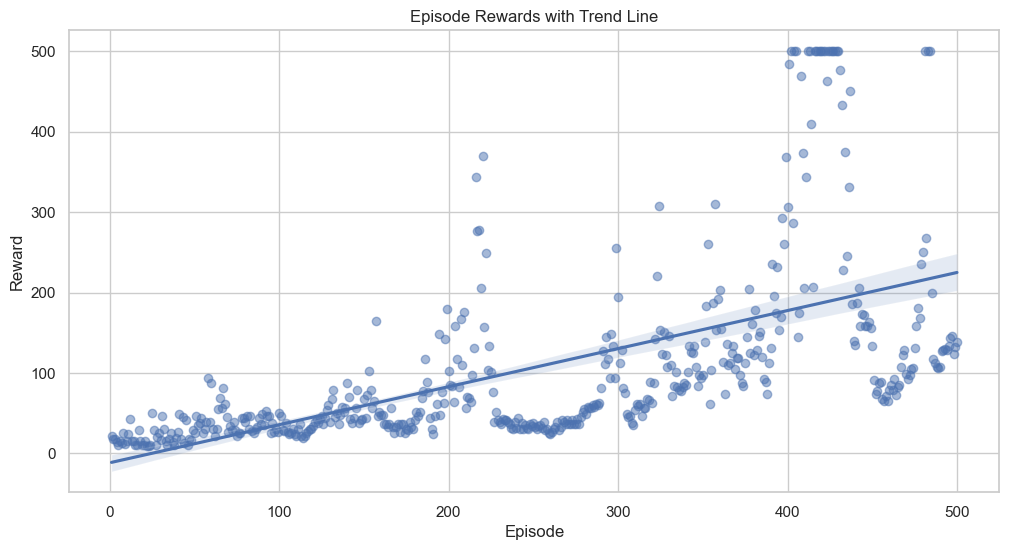

In [8]:
# Create a DataFrame for episode rewards
data = pd.DataFrame({"Episode": range(1, num_episodes + 1), "Reward": episode_rewards})

plt.figure(figsize=(12,6))
# Plot episode rewards as a scatter plot with trend line using seaborn
sns.set(style="whitegrid")
sns.regplot(data=data, x="Episode", y="Reward", scatter_kws={"alpha": 0.5})
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Episode Rewards with Trend Line")
plt.show()

### Test the trained agent

In [9]:
state= env.reset()
done=False
total_reward=0

while not done:
    action = actor(torch.from_numpy(state).float())
    dist = torch.distributions.Categorical(probs=action)
    action = dist.sample()
    next_state, reward, done, info = env.step(action.detach().numpy())
    state = next_state          
    # env.render()
    total_reward+=reward

print(f"Total reward: {total_reward}")
env.close()

Total reward: 146.0


# A2C using stable_baselines3

#### Requirements  

stable_baselines3==2.0.0
<br> gymnasium=0.28.1

#### Available RL models
| Model | Description |
|---|---|
|<a href="https://stable-baselines3.readthedocs.io/en/master/modules/a2c.html">A2C</a>| Advantage Actor Critic (A2C)|
|<a href="https://stable-baselines3.readthedocs.io/en/master/modules/ddpg.html">DDPG</a>|Deep Deterministic Policy Gradient (DDPG)|
|<a href="https://stable-baselines3.readthedocs.io/en/master/modules/dqn.html">DQN</a>|Deep Q Network (DQN)|
|<a href="https://stable-baselines3.readthedocs.io/en/master/modules/her.html">HER</a>|Hindsight Experience Replay (HER)|
|<a href="https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html">PPO</a>| Proximal Policy Optimization|
|<a href="https://stable-baselines3.readthedocs.io/en/master/modules/sac.html">SAC</a>|Soft Actor Critic (SAC) |
|<a href="https://stable-baselines3.readthedocs.io/en/master/modules/td3.html">TD3</a>|Twin Delayed DDPG (TD3) |

In [2]:
import gymnasium as gym
from stable_baselines3 import A2C
from stable_baselines3.common.evaluation import evaluate_policy

### Create environment

In [3]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

### Instantiate the agent

In [4]:
model = A2C("MlpPolicy", env, verbose=1)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


### Train the agent 

In [5]:
model.learn(total_timesteps=10000, progress_bar=True)

Output()

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 36.1     |
|    ep_rew_mean        | 36.1     |
| time/                 |          |
|    fps                | 194      |
|    iterations         | 100      |
|    time_elapsed       | 2        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.664   |
|    explained_variance | -0.0929  |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 1.74     |
|    value_loss         | 9.79     |
------------------------------------


------------------------------------
| rollout/              |          |
|    ep_len_mean        | 31.6     |
|    ep_rew_mean        | 31.6     |
| time/                 |          |
|    fps                | 193      |
|    iterations         | 200      |
|    time_elapsed       | 5        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.557   |
|    explained_variance | -0.244   |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy_loss        | 2.61     |
|    value_loss         | 12.9     |
------------------------------------


------------------------------------
| rollout/              |          |
|    ep_len_mean        | 29.2     |
|    ep_rew_mean        | 29.2     |
| time/                 |          |
|    fps                | 203      |
|    iterations         | 300      |
|    time_elapsed       | 7        |
|    total_timesteps    | 1500     |
| train/                |          |
|    entropy_loss       | -0.642   |
|    explained_variance | -0.159   |
|    learning_rate      | 0.0007   |
|    n_updates          | 299      |
|    policy_loss        | 1.37     |
|    value_loss         | 7.36     |
------------------------------------


------------------------------------
| rollout/              |          |
|    ep_len_mean        | 28.5     |
|    ep_rew_mean        | 28.5     |
| time/                 |          |
|    fps                | 208      |
|    iterations         | 400      |
|    time_elapsed       | 9        |
|    total_timesteps    | 2000     |
| train/                |          |
|    entropy_loss       | -0.564   |
|    explained_variance | -0.172   |
|    learning_rate      | 0.0007   |
|    n_updates          | 399      |
|    policy_loss        | 1.15     |
|    value_loss         | 6.75     |
------------------------------------


------------------------------------
| rollout/              |          |
|    ep_len_mean        | 28.8     |
|    ep_rew_mean        | 28.8     |
| time/                 |          |
|    fps                | 209      |
|    iterations         | 500      |
|    time_elapsed       | 11       |
|    total_timesteps    | 2500     |
| train/                |          |
|    entropy_loss       | -0.546   |
|    explained_variance | -0.00972 |
|    learning_rate      | 0.0007   |
|    n_updates          | 499      |
|    policy_loss        | 0.933    |
|    value_loss         | 5.78     |
------------------------------------


------------------------------------
| rollout/              |          |
|    ep_len_mean        | 29.8     |
|    ep_rew_mean        | 29.8     |
| time/                 |          |
|    fps                | 206      |
|    iterations         | 600      |
|    time_elapsed       | 14       |
|    total_timesteps    | 3000     |
| train/                |          |
|    entropy_loss       | -0.58    |
|    explained_variance | -0.0087  |
|    learning_rate      | 0.0007   |
|    n_updates          | 599      |
|    policy_loss        | -13.7    |
|    value_loss         | 706      |
------------------------------------


------------------------------------
| rollout/              |          |
|    ep_len_mean        | 29.4     |
|    ep_rew_mean        | 29.4     |
| time/                 |          |
|    fps                | 205      |
|    iterations         | 700      |
|    time_elapsed       | 17       |
|    total_timesteps    | 3500     |
| train/                |          |
|    entropy_loss       | -0.428   |
|    explained_variance | -0.0722  |
|    learning_rate      | 0.0007   |
|    n_updates          | 699      |
|    policy_loss        | 1.6      |
|    value_loss         | 5.03     |
------------------------------------


------------------------------------
| rollout/              |          |
|    ep_len_mean        | 31.8     |
|    ep_rew_mean        | 31.8     |
| time/                 |          |
|    fps                | 207      |
|    iterations         | 800      |
|    time_elapsed       | 19       |
|    total_timesteps    | 4000     |
| train/                |          |
|    entropy_loss       | -0.545   |
|    explained_variance | -0.00143 |
|    learning_rate      | 0.0007   |
|    n_updates          | 799      |
|    policy_loss        | 0.76     |
|    value_loss         | 4.32     |
------------------------------------


------------------------------------
| rollout/              |          |
|    ep_len_mean        | 35.5     |
|    ep_rew_mean        | 35.5     |
| time/                 |          |
|    fps                | 210      |
|    iterations         | 900      |
|    time_elapsed       | 21       |
|    total_timesteps    | 4500     |
| train/                |          |
|    entropy_loss       | -0.548   |
|    explained_variance | 0.000111 |
|    learning_rate      | 0.0007   |
|    n_updates          | 899      |
|    policy_loss        | 1.03     |
|    value_loss         | 3.73     |
------------------------------------


-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 40.2      |
|    ep_rew_mean        | 40.2      |
| time/                 |           |
|    fps                | 212       |
|    iterations         | 1000      |
|    time_elapsed       | 23        |
|    total_timesteps    | 5000      |
| train/                |           |
|    entropy_loss       | -0.545    |
|    explained_variance | -0.000217 |
|    learning_rate      | 0.0007    |
|    n_updates          | 999       |
|    policy_loss        | 0.46      |
|    value_loss         | 3.22      |
-------------------------------------


-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 43.6      |
|    ep_rew_mean        | 43.6      |
| time/                 |           |
|    fps                | 214       |
|    iterations         | 1100      |
|    time_elapsed       | 25        |
|    total_timesteps    | 5500      |
| train/                |           |
|    entropy_loss       | -0.573    |
|    explained_variance | -0.000671 |
|    learning_rate      | 0.0007    |
|    n_updates          | 1099      |
|    policy_loss        | 0.586     |
|    value_loss         | 2.73      |
-------------------------------------


------------------------------------
| rollout/              |          |
|    ep_len_mean        | 48       |
|    ep_rew_mean        | 48       |
| time/                 |          |
|    fps                | 212      |
|    iterations         | 1200     |
|    time_elapsed       | 28       |
|    total_timesteps    | 6000     |
| train/                |          |
|    entropy_loss       | -0.497   |
|    explained_variance | 0.00115  |
|    learning_rate      | 0.0007   |
|    n_updates          | 1199     |
|    policy_loss        | 0.935    |
|    value_loss         | 2.28     |
------------------------------------


-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 51.5      |
|    ep_rew_mean        | 51.5      |
| time/                 |           |
|    fps                | 211       |
|    iterations         | 1300      |
|    time_elapsed       | 30        |
|    total_timesteps    | 6500      |
| train/                |           |
|    entropy_loss       | -0.502    |
|    explained_variance | -8.18e-05 |
|    learning_rate      | 0.0007    |
|    n_updates          | 1299      |
|    policy_loss        | 0.907     |
|    value_loss         | 1.88      |
-------------------------------------


------------------------------------
| rollout/              |          |
|    ep_len_mean        | 57.1     |
|    ep_rew_mean        | 57.1     |
| time/                 |          |
|    fps                | 211      |
|    iterations         | 1400     |
|    time_elapsed       | 33       |
|    total_timesteps    | 7000     |
| train/                |          |
|    entropy_loss       | -0.425   |
|    explained_variance | 0.000886 |
|    learning_rate      | 0.0007   |
|    n_updates          | 1399     |
|    policy_loss        | 0.579    |
|    value_loss         | 1.51     |
------------------------------------


-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 61.1      |
|    ep_rew_mean        | 61.1      |
| time/                 |           |
|    fps                | 212       |
|    iterations         | 1500      |
|    time_elapsed       | 35        |
|    total_timesteps    | 7500      |
| train/                |           |
|    entropy_loss       | -0.508    |
|    explained_variance | -0.000221 |
|    learning_rate      | 0.0007    |
|    n_updates          | 1499      |
|    policy_loss        | 0.291     |
|    value_loss         | 1.19      |
-------------------------------------


-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 65.5      |
|    ep_rew_mean        | 65.5      |
| time/                 |           |
|    fps                | 211       |
|    iterations         | 1600      |
|    time_elapsed       | 37        |
|    total_timesteps    | 8000      |
| train/                |           |
|    entropy_loss       | -0.406    |
|    explained_variance | -0.000614 |
|    learning_rate      | 0.0007    |
|    n_updates          | 1599      |
|    policy_loss        | 0.162     |
|    value_loss         | 0.909     |
-------------------------------------


------------------------------------
| rollout/              |          |
|    ep_len_mean        | 69.5     |
|    ep_rew_mean        | 69.5     |
| time/                 |          |
|    fps                | 209      |
|    iterations         | 1700     |
|    time_elapsed       | 40       |
|    total_timesteps    | 8500     |
| train/                |          |
|    entropy_loss       | -0.217   |
|    explained_variance | 0.000251 |
|    learning_rate      | 0.0007   |
|    n_updates          | 1699     |
|    policy_loss        | 0.859    |
|    value_loss         | 0.661    |
------------------------------------


------------------------------------
| rollout/              |          |
|    ep_len_mean        | 73.1     |
|    ep_rew_mean        | 73.1     |
| time/                 |          |
|    fps                | 208      |
|    iterations         | 1800     |
|    time_elapsed       | 43       |
|    total_timesteps    | 9000     |
| train/                |          |
|    entropy_loss       | -0.407   |
|    explained_variance | 1.48e-05 |
|    learning_rate      | 0.0007   |
|    n_updates          | 1799     |
|    policy_loss        | 0.402    |
|    value_loss         | 0.457    |
------------------------------------


-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 77.8      |
|    ep_rew_mean        | 77.8      |
| time/                 |           |
|    fps                | 209       |
|    iterations         | 1900      |
|    time_elapsed       | 45        |
|    total_timesteps    | 9500      |
| train/                |           |
|    entropy_loss       | -0.355    |
|    explained_variance | -1.78e-05 |
|    learning_rate      | 0.0007    |
|    n_updates          | 1899      |
|    policy_loss        | 0.365     |
|    value_loss         | 0.294     |
-------------------------------------


------------------------------------
| rollout/              |          |
|    ep_len_mean        | 80.7     |
|    ep_rew_mean        | 80.7     |
| time/                 |          |
|    fps                | 210      |
|    iterations         | 2000     |
|    time_elapsed       | 47       |
|    total_timesteps    | 10000    |
| train/                |          |
|    entropy_loss       | -0.566   |
|    explained_variance | 6.41e-05 |
|    learning_rate      | 0.0007   |
|    n_updates          | 1999     |
|    policy_loss        | 0.116    |
|    value_loss         | 0.162    |
------------------------------------


### Save the agent

In [6]:
model.save("a2c_cartpole")
del model  # delete trained model to demonstrate loading

### Load the trained agent
#### NOTE: if you have loading issue, you can pass `print_system_info=True` to compare the system on which the model was trained vs the current one

In [7]:
model = A2C.load("a2c_cartpole", env=env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


### Test the trained agent

In [8]:
mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=10)

vec_env = model.get_env()
obs = vec_env.reset()
for i in range(1000):
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, dones, info = vec_env.step(action)
    vec_env.render("human")